

# 1. Introdução e Metadados

### 1.1. Contexto e Fontes de Dados

Os dados foram obtidos a partir da plataforma [Kaggle](https://www.kaggle.com/), especificamente do conjunto:

- **Fonte Principal:** [Microsoft Security Incident Prediction – GUIDE_Train.csv](https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction/data?select=GUIDE_Train.csv)

- **Dicionário de Dados Local:** `raw/Dicionario_Dados_Security_Incident.md`

- **Fonte Original:** Telemetria de máquinas Windows coletada pela Microsoft para identificar padrões de incidentes de segurança.

### Sobre o Problema

O objetivo é prever a ocorrência de incidente de segurança (classificação binária), onde a variável alvo esperada é `HasDetections`, conforme o dicionário de dados.

### 1.2. Sobre o Dataset e Estrutura

O dataset descreve características de máquinas Windows e sua propensão a incidentes de segurança. As informações abrangem:

- **Características do Sistema:** Informações sobre o sistema operacional, versão, arquitetura e configurações.
- **Hardware:** Dados sobre processador, memória RAM, espaço em disco e outros componentes.
- **Software:** Informações sobre programas instalados, versões e configurações.
- **Telemetria:** Dados de uso e comportamento do sistema.

### 1.3. Desafios de Qualidade e Limitações Iniciais

- **Alta Dimensionalidade:** Muitas features podem ser irrelevantes ou redundantes.
- **Dados Ausentes:** Presença significativa de valores faltantes.
- **Desbalanceamento de Classes:** Possível desbalanceamento entre classes.
- **Engenharia de Features:** Criação/transformação de variáveis para melhor performance.


# 2. Análise Exploratória

A seguir, utilizaremos Python para auxiliar na análise dos dados brutos. Com a biblioteca [`Pandas`](https://pandas.pydata.org/), podemos visualizar e alterar os dados utilizando `Dataframes` e `Series`. Uma `Series` é um array unidimensional, e um `Dataframe` é como uma tabela, em que cada coluna é uma `Series`.  

Além dessas bibliotecas, também podemos usar a `seaborn` para desenhar gráficos com base nos dados das `Series` e `Dataframes`.


## 2.1 Importação das bibliotecas e carregamento do Dataset


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configurações para melhor visualização
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [4]:
# Carregamento do dataset com fallback inteligente e parsing de datas
# Preferir arquivo da competição (GUIDE_Train.csv); caso não exista, usar train.csv
import os

candidate_paths = [
    "./train.csv",
]

chosen_path = None
for path in candidate_paths:
    if os.path.exists(path):
        chosen_path = path
        break

if chosen_path is None:
    raise FileNotFoundError("Nenhum arquivo de treino encontrado. Esperado: GUIDE_Train.csv ou train.csv na pasta ./raw.")

parse_dates = [col for col in ["Timestamp", "Date", "EventTime"] if os.path.exists(chosen_path)]

df = pd.read_csv(
    chosen_path,
    sep=",",
    encoding="utf8",
    low_memory=False,
)

# Tentar converter colunas de tempo comuns para datetime se existirem
for time_col in ["Timestamp", "Date", "EventTime"]:
    if time_col in df.columns:
        try:
            df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        except Exception:
            pass

print(f"Arquivo carregado: {chosen_path}")


Arquivo carregado: ./train.csv


## 2.2 Head do Dataset


A tabela apresentada mostra as cinco primeiras entradas do nosso conjunto de dados, o que nos permite uma verificação inicial das colunas disponíveis e dos tipos de dados que elas contêm.


In [5]:
df.head(5)


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04 06:05:15+00:00,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14 03:01:25+00:00,58,43,Exfiltration,NaN,FalsePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13 04:52:55+00:00,423,298,InitialAccess,T1189,FalsePositive,NaN,NaN,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10 16:39:36+00:00,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15 01:08:07+00:00,9,74,Execution,NaN,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


## 2.3 Dimensões do Dataset


Após a primeira visualização, o próximo passo é verificar as dimensões do nosso conjunto de dados. A "dimensão" de um dataset refere-se à sua estrutura em termos de quantidade de linhas e colunas.

Conforme o resultado abaixo, nosso dataset é composto por um grande número de linhas e colunas, o que nos dá uma noção do volume de dados que iremos analisar.


In [6]:
linhas, colunas = df.shape

print(f"Número de tuplas: {linhas:,}")
print(f"Número de colunas: {colunas}")


Número de tuplas: 9,516,837
Número de colunas: 45


## 2.4 Identificação das Colunas e Tipos de Dados


Agora que conhecemos as dimensões gerais do nosso dataset, o próximo passo é nos aprofundarmos nessas colunas. Precisamos identificar o nome de cada uma das variáveis que temos à disposição para entender com quais informações estamos trabalhando.

O comando a seguir listará todas as colunas, dando uma visão dos atributos disponíveis para cada máquina.


In [7]:
print(f"Total de colunas: {len(df.columns)}")

print("\nTodas as colunas:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")



Total de colunas: 45

Todas as colunas:
 1. Id
 2. OrgId
 3. IncidentId
 4. AlertId
 5. Timestamp
 6. DetectorId
 7. AlertTitle
 8. Category
 9. MitreTechniques
10. IncidentGrade
11. ActionGrouped
12. ActionGranular
13. EntityType
14. EvidenceRole
15. DeviceId
16. Sha256
17. IpAddress
18. Url
19. AccountSid
20. AccountUpn
21. AccountObjectId
22. AccountName
23. DeviceName
24. NetworkMessageId
25. EmailClusterId
26. RegistryKey
27. RegistryValueName
28. RegistryValueData
29. ApplicationId
30. ApplicationName
31. OAuthApplicationId
32. ThreatFamily
33. FileName
34. FolderPath
35. ResourceIdName
36. ResourceType
37. Roles
38. OSFamily
39. OSVersion
40. AntispamDirection
41. SuspicionLevel
42. LastVerdict
43. CountryCode
44. State
45. City


Com os nomes das colunas já identificados, vamos entender como os dados de cada variável estão sendo interpretados. Verificar os tipos de dados (dtypes) é um passo importante para garantir a integridade da análise e planejar a etapa de limpeza.

O resultado a seguir nos revela a distribuição dos tipos de dados no dataset.


In [8]:
# Análise dos tipos de dados
dtype_counts = df.dtypes.value_counts()
print("Distribuição dos tipos de dados:")
print(dtype_counts)

print("\nDetalhamento por tipo:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"\n{dtype}: {len(cols)} colunas")
    if len(cols) <= 10:
        print(f"  {cols}")
    else:
        print(f"  {cols[:10]} ... e mais {len(cols)-10} colunas")


Distribuição dos tipos de dados:
int64                  30
object                 13
datetime64[ns, UTC]     1
float64                 1
Name: count, dtype: int64

Detalhamento por tipo:

int64: 30 colunas
  ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle', 'DeviceId', 'Sha256', 'IpAddress', 'Url'] ... e mais 20 colunas

datetime64[ns, UTC]: 1 colunas
  ['Timestamp']

object: 13 colunas
  ['Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'ThreatFamily', 'ResourceType', 'Roles'] ... e mais 3 colunas

float64: 1 colunas
  ['EmailClusterId']


## 2.5 Qualidade dos Dados


### 2.5.1 Análise de Valores Ausentes (Nulos/NaN)


#### Dados não nulos

Enquanto o passo anterior nos mostrou apenas os tipos de dados, a análise a seguir também revelará a quantidade de valores não nulos em cada coluna, nos dando um panorama sobre a presença de dados ausentes.

Este diagnóstico serve para identificar lacunas que precisam ser tratadas antes de qualquer análise mais profunda.


In [9]:
# Informações gerais sobre o dataset
print("Informações gerais do dataset:")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nResumo de informações:")
df.info()


Informações gerais do dataset:
Memória utilizada: 7300.76 MB

Resumo de informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype              
---  ------              -----              
 0   Id                  int64              
 1   OrgId               int64              
 2   IncidentId          int64              
 3   AlertId             int64              
 4   Timestamp           datetime64[ns, UTC]
 5   DetectorId          int64              
 6   AlertTitle          int64              
 7   Category            object             
 8   MitreTechniques     object             
 9   IncidentGrade       object             
 10  ActionGrouped       object             
 11  ActionGranular      object             
 12  EntityType          object             
 13  EvidenceRole        object             
 14  DeviceId            int64              
 15  Sha256              int64       

#### Dados nulos

No passo anterior, o método `info()` nos deu um bom indicativo da presença de dados ausentes. Para abordar esse problema, vamos calcular a soma exata de valores nulos para cada coluna do dataset.


In [10]:
# Análise de valores nulos
null_counts = df.isnull().sum()
null_percentages = (null_counts / len(df)) * 100

# Criar DataFrame com informações de nulos
null_info = pd.DataFrame({
    'Coluna': null_counts.index,
    'Valores_Nulos': null_counts.values,
    'Percentual_Nulos': null_percentages.values
})

# Ordenar por percentual de nulos
null_info = null_info.sort_values('Percentual_Nulos', ascending=False)

print("Top 20 colunas com mais valores nulos:")
print(null_info.head(20).to_string(index=False))


Top 20 colunas com mais valores nulos:
           Coluna  Valores_Nulos  Percentual_Nulos
     ResourceType        9509762         99.925658
    ActionGrouped        9460773         99.410897
   ActionGranular        9460773         99.410897
     ThreatFamily        9441956         99.213173
   EmailClusterId        9420025         98.982729
AntispamDirection        9339535         98.136965
            Roles        9298686         97.707736
   SuspicionLevel        8072708         84.825536
      LastVerdict        7282572         76.523030
  MitreTechniques        5468386         57.460120
    IncidentGrade          51340          0.539465
        Timestamp              0          0.000000
               Id              0          0.000000
       EntityType              0          0.000000
       DetectorId              0          0.000000
       AlertTitle              0          0.000000
         Category              0          0.000000
            OrgId              0          0

### 2.5.2 Análise da Variável Target


Para um problema de classificação binária, é fundamental entender a distribuição da variável target. Vamos analisar a variável `HasDetections` que indica se a máquina foi infectada por malware.


In [11]:
# Análise da variável target com detecção flexível
possible_target_names = [
    "HasDetections", "hasdetections", "Label", "label", "Target", "target",
    "HasIncident", "hasincident", "Incident", "incident"
]

target_col = None
for name in possible_target_names:
    for col in df.columns:
        if col.lower() == name.lower():
            target_col = col
            break
    if target_col is not None:
        break

if target_col is not None:
    target_series = df[target_col].astype("float").astype("Int64", errors="ignore") if df[target_col].dtype == object else df[target_col]
    target_counts = target_series.value_counts(dropna=False)
    target_percentages = target_series.value_counts(normalize=True, dropna=False) * 100

    print(f"Variável target detectada: '{target_col}'")
    print("Distribuição da variável target:")
    print(f"\nContagem:")
    for value, count in target_counts.items():
        perc = target_percentages[value]
        print(f"  {value}: {count:,} ({perc:.2f}%)")

    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=target_series, palette=['#5bc0de', '#d9534f'])
    ax.set_title(f"Distribuição da Variável Target ({target_col})")
    ax.set_xlabel(f"{target_col}")
    ax.set_ylabel("Contagem")

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + max(1, height*0.01), f"{height:,}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    if target_counts.shape[0] >= 2:
        majority = int(target_counts.max())
        minority = int(target_counts.min())
        balance_ratio = minority / majority if majority > 0 else np.nan
        print(f"\nRazão de balanceamento: {balance_ratio:.3f}")
        if balance_ratio < 0.1:
            print("⚠️  Dataset altamente desbalanceado!")
        elif balance_ratio < 0.3:
            print("⚠️  Dataset moderadamente desbalanceado")
        else:
            print("✅ Dataset relativamente balanceado")
else:
    print("Variável target não encontrada. Esperado algo como 'HasDetections' ou 'Label'.")
    potential_targets = [col for col in df.columns if any(k in col.lower() for k in ["detect", "target", "label", "incident"]) ]
    if potential_targets:
        print("Colunas candidatas encontradas:", potential_targets)
    else:
        print("Nenhuma coluna target óbvia encontrada.")


Variável target não encontrada. Esperado algo como 'HasDetections' ou 'Label'.
Colunas candidatas encontradas: ['IncidentId', 'DetectorId', 'IncidentGrade']


### Conclusão da Análise Exploratória e Próximos Passos


A fase de Análise Exploratória de Dados foi concluída, nos fornecendo um panorama sobre a estrutura, a qualidade e as características do nosso conjunto de dados. Através desta investigação, embora rico em informações, o dataset possui diversas características que precisam ser consideradas antes de qualquer análise aprofundada.

Os principais achados identificados foram:

- **Dimensões do Dataset:** Um dataset de grande escala com muitas observações e features.
- **Dados Ausentes:** Presença de valores faltantes que precisarão de estratégias de tratamento.
- **Dados Duplicados:** Verificação da existência de registros duplicados.
- **Variável Target:** Análise da distribuição da variável `HasDetections` e verificação de balanceamento.
- **Correlações:** Identificação de variáveis altamente correlacionadas que podem ser redundantes.
- **Variabilidade:** Análise de valores únicos para identificar variáveis constantes ou com baixa variabilidade.

A conclusão desta etapa é que o dataset em seu estado bruto apresenta características típicas de dados de telemetria de sistemas, com alta dimensionalidade e complexidade. Portanto, o próximo passo será focado na **Engenharia de Features** e **Limpeza de Dados**, onde iremos executar um plano para otimizar o dataset para modelagem de Machine Learning.


## 3. Análise de Outliers

A detecção de outliers é importante para entender valores extremos que podem distorcer análises e modelos. Abaixo apresentamos duas abordagens complementares:

- Z-score (baseada em desvio-padrão)
- IQR (baseada em quartis/boxplot)

Para desempenho, utilizamos uma amostra aleatória quando o dataset é muito grande.


### 3.1 Outliers por Z-score

Aplicamos o Z-score em colunas numéricas para identificar pontos com valor absoluto acima de um limiar (|z| > 3 por padrão). Apresentamos boxplots e distribuições para as variáveis mais relevantes.


Usando amostra de 100,000 linhas para gráficos.
Top 10 colunas com maior proporção de outliers (Z-score > 3):


FolderPath          0.07620
CountryCode         0.07347
FileName            0.07333
State               0.06463
City                0.06418
Sha256              0.06321
DeviceName          0.06011
Url                 0.05791
NetworkMessageId    0.05720
DeviceId            0.03300
dtype: float64

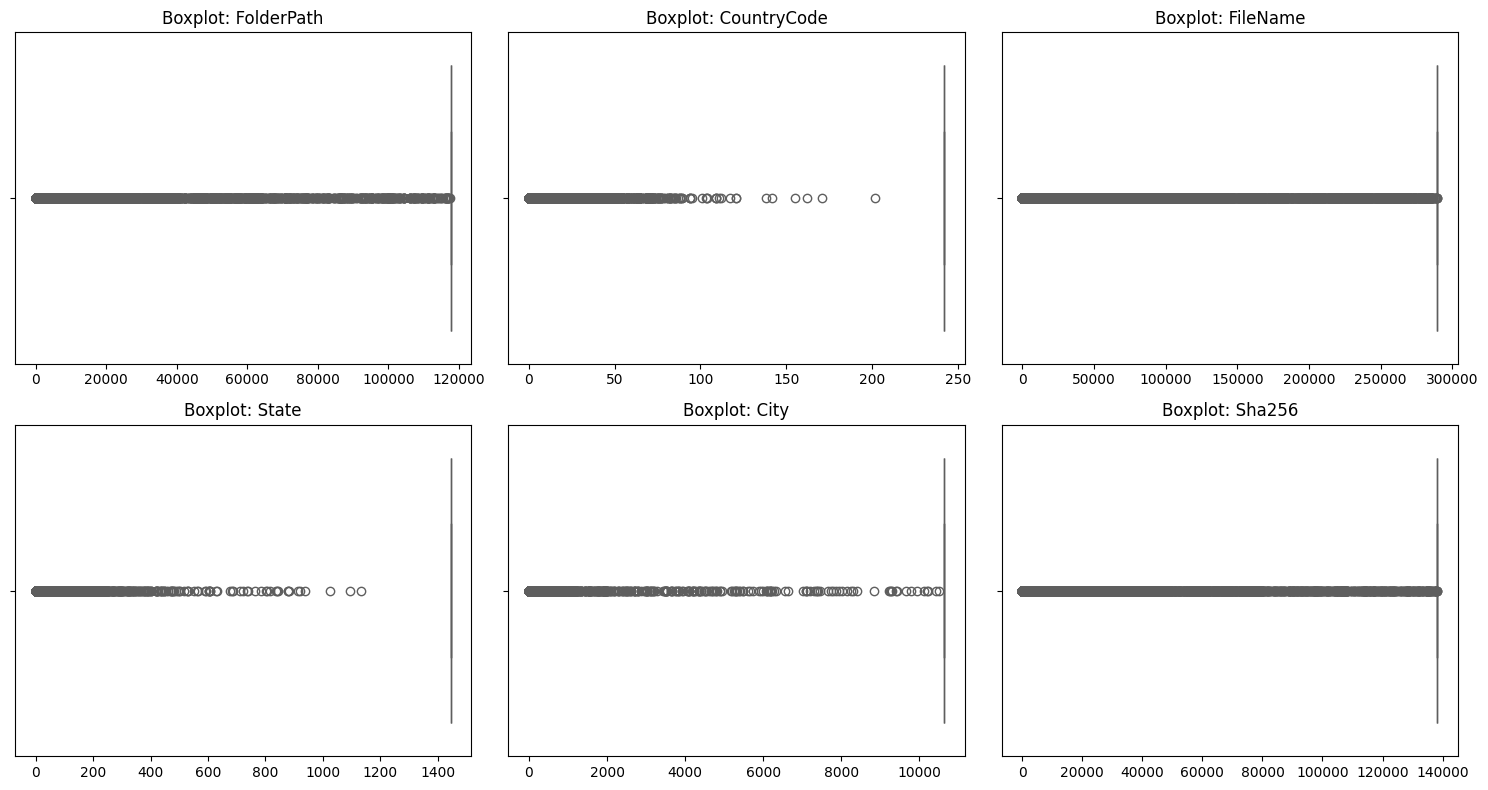

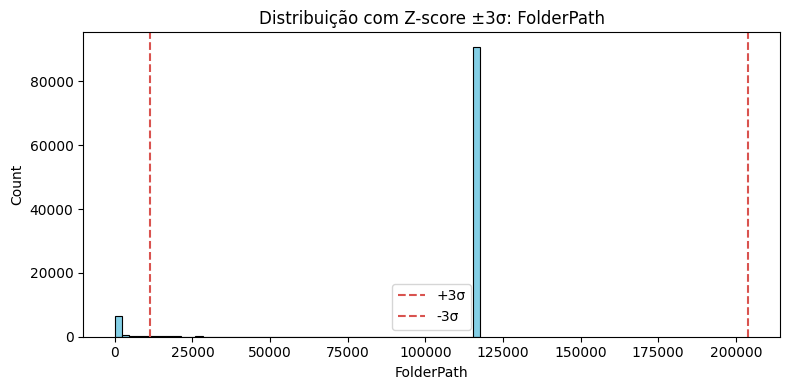

In [12]:
# Selecionar colunas numéricas e amostrar dados para performance
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) == 0:
    print("Não há colunas numéricas para análise de outliers por Z-score.")
else:
    plot_sample_size = 100_000
    sample_df = df[numeric_cols]
    if len(df) > plot_sample_size:
        sample_df = df[numeric_cols].sample(n=plot_sample_size, random_state=42)
        print(f"Usando amostra de {plot_sample_size:,} linhas para gráficos.")
    else:
        print(f"Usando dataset completo com {len(df):,} linhas para gráficos.")

    # Calcular Z-score manualmente por coluna (evitar dependência externa)
    means = sample_df.mean(numeric_only=True)
    stds = sample_df.std(numeric_only=True).replace(0, np.nan)
    z_scores = (sample_df - means) / stds

    # Proporção de outliers por coluna
    threshold = 3.0
    outlier_ratio = (np.abs(z_scores) > threshold).sum() / z_scores.shape[0]
    outlier_ratio = outlier_ratio.sort_values(ascending=False)

    print("Top 10 colunas com maior proporção de outliers (Z-score > 3):")
    display(outlier_ratio.head(10))

    # Boxplots das top N colunas com mais outliers
    top_n = 6
    top_cols = outlier_ratio.head(top_n).index.tolist()

    if len(top_cols) > 0:
        ncols = 3
        nrows = int(np.ceil(len(top_cols) / ncols))
        plt.figure(figsize=(5*ncols, 4*nrows))
        for i, col in enumerate(top_cols, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x=sample_df[col], color="#5bc0de")
            plt.title(f"Boxplot: {col}")
            plt.xlabel("")
        plt.tight_layout()
        plt.show()

        # Distribuição com linhas de threshold para a primeira coluna
        col0 = top_cols[0]
        plt.figure(figsize=(8, 4))
        sns.histplot(sample_df[col0].dropna(), bins=50, color="#5bc0de")
        mu = sample_df[col0].mean()
        sigma = sample_df[col0].std()
        if sigma > 0:
            plt.axvline(mu + threshold * sigma, color="#d9534f", linestyle="--", label="+3σ")
            plt.axvline(mu - threshold * sigma, color="#d9534f", linestyle="--", label="-3σ")
            plt.legend()
        plt.title(f"Distribuição com Z-score ±3σ: {col0}")
        plt.tight_layout()
        plt.show()


### 3.2 Outliers por IQR (Boxplot)

A abordagem por IQR identifica outliers abaixo de Q1 − 1.5×IQR e acima de Q3 + 1.5×IQR. Plotamos boxplots das colunas com maiores taxas de outliers por essa métrica.


Usando amostra de 100,000 linhas para gráficos.
Top 10 colunas com maior proporção de outliers (IQR):


AccountName       0.24917
AlertTitle        0.19907
DetectorId        0.14623
OrgId             0.12042
IncidentId        0.11586
AlertId           0.00466
EmailClusterId    0.00031
DeviceId          0.00000
Sha256            0.00000
Url               0.00000
dtype: float64

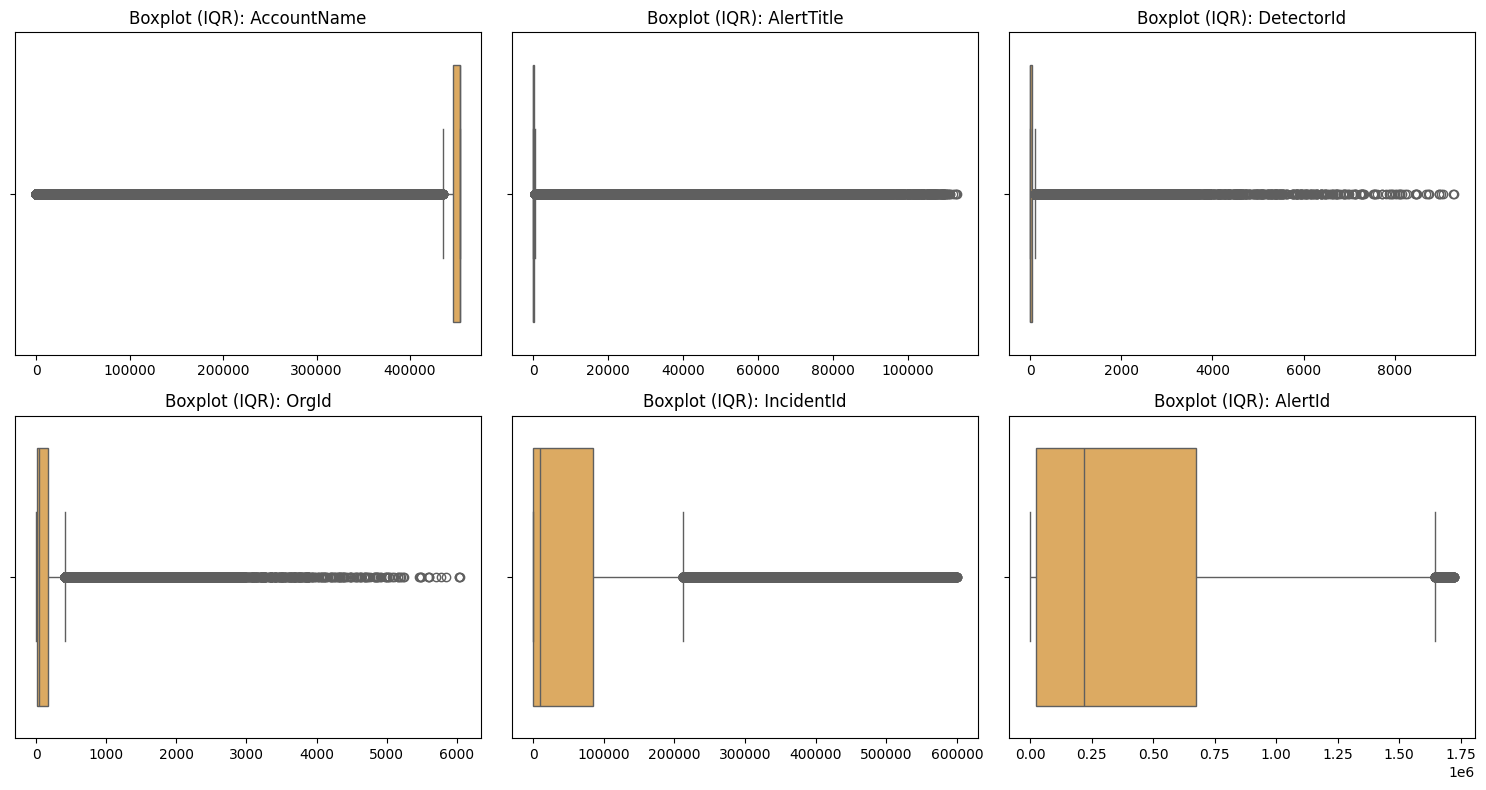

In [13]:
# Cálculo de outliers via IQR e visualização
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) == 0:
    print("Não há colunas numéricas para análise de outliers por IQR.")
else:
    plot_sample_size = 100_000
    sample_df = df[numeric_cols]
    if len(df) > plot_sample_size:
        sample_df = df[numeric_cols].sample(n=plot_sample_size, random_state=42)
        print(f"Usando amostra de {plot_sample_size:,} linhas para gráficos.")
    else:
        print(f"Usando dataset completo com {len(df):,} linhas para gráficos.")

    # Função para taxa de outliers IQR por coluna
    def iqr_outlier_ratio(series):
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        if not np.isfinite(iqr) or iqr == 0:
            return 0.0
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = (series < lower) | (series > upper)
        return mask.mean()

    ratios = sample_df.apply(iqr_outlier_ratio).sort_values(ascending=False)

    print("Top 10 colunas com maior proporção de outliers (IQR):")
    display(ratios.head(10))

    # Boxplots das top N colunas
    top_n = 6
    top_cols = ratios.head(top_n).index.tolist()

    if len(top_cols) > 0:
        ncols = 3
        nrows = int(np.ceil(len(top_cols) / ncols))
        plt.figure(figsize=(5*ncols, 4*nrows))
        for i, col in enumerate(top_cols, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x=sample_df[col], color="#f0ad4e")
            plt.title(f"Boxplot (IQR): {col}")
            plt.xlabel("")
        plt.tight_layout()
        plt.show()



## 2.6 Validação rápida contra o Dicionário de Dados

Checamos a presença de algumas colunas-chave esperadas segundo `Dicionario_Dados_Security_Incident.md` e a página do Kaggle. Isso ajuda a diagnosticar se o arquivo carregado corresponde ao dataset esperado.


In [14]:
expected_core = [
    "MachineIdentifier", "HasDetections", "ProductName", "EngineVersion", "AppVersion",
    "AvSigVersion", "Platform", "Processor", "OsVer", "Census_OSVersion", "Census_OSArchitecture",
]

present = [c for c in expected_core if c in df.columns]
missing = [c for c in expected_core if c not in df.columns]

print("Colunas esperadas encontradas:", present)
print("Colunas esperadas ausentes:", missing)

if len(present) == 0:
    print("Aviso: O arquivo carregado pode não ser o GUIDE_Train.csv do Kaggle.\n"
          "Verifique o caminho do arquivo carregado impresso acima e garanta que o dataset correto está na pasta.")



Colunas esperadas encontradas: []
Colunas esperadas ausentes: ['MachineIdentifier', 'HasDetections', 'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'Census_OSVersion', 'Census_OSArchitecture']
Aviso: O arquivo carregado pode não ser o GUIDE_Train.csv do Kaggle.
Verifique o caminho do arquivo carregado impresso acima e garanta que o dataset correto está na pasta.
